In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import copy
import nltk
from sklearn import preprocessing
from keras.utils import plot_model
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from itertools import islice
import os
import regex as re
import nltk 
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import tree2conlltags
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input
from keras.layers import concatenate, Input, Lambda, Dense, Flatten, Conv1D, Conv3D, Conv2D, Activation, MaxPooling2D, Dropout, MaxPool1D, MaxPool2D, Embedding
from keras import optimizers
from keras.models import Model
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from termcolor import colored
from tensorflow.keras.callbacks import ReduceLROnPlateau
import datetime
import tensorboard
import os
from sklearn.preprocessing import OneHotEncoder
%load_ext tensorboard
!rm -rf ./logs/ 


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Email

In [ ]:
def extract_emailid(text):
    email_per_line_list = []
    emails = re.findall("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)", text)
    for mail in emails:
        email_per_line_list.append(mail)
        
    return email_per_line_list
    

In [ ]:
def get_emails_from_file(file):
    # file = open(os.path.join(path, file))
    # file_lines = file.readlines()
    with open(path+file, encoding="utf8", errors='ignore') as f:
      file_lines = f.readlines()

    emails_in_file = []
    emails_preprocessed_list = []
    emails_preprocessed_string = ""
    
    for line in file_lines:
        email_per_line_list = []
        emails = re.findall("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)", line)
        for mail in emails:
            emails_in_file.append(mail)
    
    
    
    for i, email in enumerate(emails_in_file):
        email = email.split("@", 1)[1]
        email = email.split('.')
        for c in email:
            if c=="com":
                email.remove(c)
            else:
                emails_preprocessed_list.append(c)
    
    emails_preprocessed_list = list(set(emails_preprocessed_list))
    
    for c in emails_preprocessed_list:
        c.lower()
        if c.find('-') != -1:
            c = c.replace("-","")
        if len(c) > 2:
            if len(emails_preprocessed_string) == 0:
                emails_preprocessed_string = emails_preprocessed_string + c
            else:
                emails_preprocessed_string = emails_preprocessed_string + " " + c
    
    
    return emails_preprocessed_string, emails_in_file, emails_preprocessed_list
            

# Subject

In [ ]:
bad_chars = [';', ':', '!', "*", "\n", "\t"]

def get_subject_from_file(file):

    with open(path+file, encoding="utf8", errors='ignore') as f:
      file_lines = f.readlines()

    # file = open(os.path.join(path, file))
    # file_lines = file.readlines()
    subject_in_file = []
    subject_preprocessed_list = []
    subjects_preprocessed_strings = ""
    
    
#     line = re.sub(' Re: ',"", line)
#             line = line.rstrip('\n')
#             line = line.rstrip('\t')
#             line = re.sub(r'[^\w\s]', '', line)
#             line = ''.join(i for i in line if not i in bad_chars)
    
    for line in file_lines:
        if (line.find('Subject: ')!=-1):
            line = line.split('Subject: ')[1]
            line = line.rstrip('\n')
            line = line.rstrip('\t')
            line = re.sub(r'[^\w\s]', ' ', line)
            line = re.sub(' Re ',"", line)
            line = re.sub("  ", "", line)
            line = ''.join(i for i in line if not i in bad_chars)
            line = line.lstrip()
            subject_in_file.append(line)
            
    if len(subject_in_file) == 1:
        for i, c in enumerate(subject_in_file):
            if i==0 and c==" ":
                continue
            elif (i==1 and c==" "):
                continue
            else:
                subjects_preprocessed_strings = subjects_preprocessed_strings + c
            
    if len(subject_in_file) > 1:
        for item in subject_in_file:
            for i, c in enumerate(item):
                if i==0 and c==" ":
                    continue
                elif (i==1 and c==" "):
                    continue
                else:
                    subjects_preprocessed_strings = subjects_preprocessed_strings + c
                
    
    subjects_preprocessed_strings = re.sub('  ',"", subjects_preprocessed_strings)
    
    
    return file, subjects_preprocessed_strings
            
    

# Text

In [ ]:

bad_chars = [';', ':', '!', "*", "\n", "\t", '\\','/', "-", "@", "#", "$", "%", "^", "&", '"', '.', ',', ')', '(', '[', ']', '{', '}']



# Remove words of len<=2 and >=15
def removeWord_with_len(line):
    wordList = word_tokenize(line)
    
    for i, word in enumerate(wordList):
        if len(word)<=2:
            wordList[i] = ""
        if len(word)>=15:
            wordList[i] = ""
    new_line = TreebankWordDetokenizer().detokenize(wordList)
    return new_line
    
            

# Remove _word, word_, _word_ and keep word2 in word1_word2
def remove_word_type(line):
    
    wordlist = word_tokenize(line)
    
    for i, word in enumerate(wordlist):
        if ((re.search(r"^_\w.*_", word)) or (re.search(r"^_\w.*", word)) or (re.search(r"^\w.*_", word)) ):
            wordlist.pop(i)
        elif (re.search(r"^\w.*_\w.*", word)):
            
            subword_list = word.split("_")
            new_word = subword_list[1]
            index_of_word = wordlist.index(word)
            wordlist[index_of_word] = new_word
            
    line = TreebankWordDetokenizer().detokenize(wordlist)
    return line
        


def remove_person_name(sentence):
    
    personNames = []
    wordsList = word_tokenize(sentence)
    for item in tree2conlltags(ne_chunk(pos_tag(wordsList))):
        if 'PERSON' in item[2]:
            personNames.append(item[0])
    
    return personNames
    


def get_text_from_file(file):
    text_in_file = []
    text_preprocessed_list = []
    text_preprocessed_strings = ""

    with open(path+file, encoding="utf8", errors='ignore') as f:
      file_lines = f.readlines()
    
    # file = open(os.path.join(path, file))
    # file_lines = file.readlines()
    
    for line in file_lines:
        # regex pattern --> word:
        if re.search(r"^\w.*:", line):
            continue
        # Remove [words]
        pattern = r"(\[(?:\[??[^\[]*?\]))"
        line = re.sub(pattern, "", line)
        
        # Remove (words)
        pattern = r".*?\((.*?)\)"
        line = re.sub(pattern, "", line)
        
        # Remove <words>
        pattern = r".*?\<(.*?)\>"
        line = re.sub(pattern, "", line)
        
        line = ''.join(i for i in line if not i in bad_chars)
        
        line = line.rstrip("\n")
        line = line.rstrip("\t")
        line = line.rstrip("--")
        line = line.lstrip()
        
        # specific
        line = re.sub(r"won't", "will not", line)
        line = re.sub(r"can\'t", "can not", line)

        # general
        line = re.sub(r"n\'t", " not", line)
        line = re.sub(r"\'re", " are", line)
        line = re.sub(r"\'s", " is", line)
        line = re.sub(r"\'d", " would", line)
        line = re.sub(r"\'ll", " will", line)
        line = re.sub(r"\'t", " not", line)
        line = re.sub(r"\'ve", " have", line)
        line = re.sub(r"\'m", " am", line)
                           
        for c in line:
            line = line.replace('\\', '')
            line = line.replace('/', '')
            
            
        # remove person names
        personNames = remove_person_name(line)        
        for name in personNames:
            line = line.rstrip(name)
            
        # remove digits
        line = ''.join([i for i in line if not i.isdigit()]) 
        
        # remove words like _word, word_, _word_ and [get word2 from pattern word1_word2]
        line = remove_word_type(line)
        
        
        # convert to lower case
        line = line.lower()
        
        # remove words that are <=2 and >=15
        line = removeWord_with_len(line)
        
        # remove all the words except (a-zA-Z and space)
        line = re.sub(r'[^a-zA-Z ]+', '', line)
        
        if line.strip() == "":
            continue
            
        text_in_file.append(line)
        
    if len(text_in_file) == 1:
        for i, c in enumerate(text_in_file):
            if i==0 and c==" ":
                continue
            elif (i==1 and c==" "):
                continue
            else:
                text_preprocessed_strings = text_preprocessed_strings + c
            
    if len(text_in_file) > 1:
        for item in text_in_file:
            for i, c in enumerate(item):
                if i==0 and c==" ":
                    continue
                elif (i==1 and c==" "):
                    continue
                else:
                    text_preprocessed_strings = text_preprocessed_strings + c
                
    
    text_preprocessed_strings = re.sub('  ',"", text_preprocessed_strings)
        
    return text_preprocessed_strings
        

# Raw Text

In [ ]:
def get_raw_text_from_file(file):
    text_in_file = []
    raw_text_string = ""
    
    with open(path+file, encoding="utf8", errors='ignore') as f:
      file_lines = f.readlines()
    
    for line in file_lines:
        text_in_file.append(line)
    
    if len(text_in_file) == 1:
        for i, c in enumerate(text_in_file):
            raw_text_string = raw_text_string + c
                
    if len(text_in_file) > 1:
        for item in text_in_file:
            for i, c in enumerate(item):
                raw_text_string = raw_text_string + c
                
    return raw_text_string
                
    
                
    
    
    

# Extracting emails, subject and texts from all files

In [ ]:
def pre_process_text_file(file_list):
    preprocessed_email_list = []
    preprocessed_subject_list = []
    preprocessed_text_list = []
    raw_text_list = []

    for i, file in enumerate(file_list):
        
        preprocessed_subject_list.append(get_subject_from_file(file)[1])
        preprocessed_email_list.append(get_emails_from_file(file)[0])
        preprocessed_text_list.append(get_text_from_file(file))
        raw_text_list.append(get_raw_text_from_file(file))
        
    return preprocessed_subject_list, preprocessed_email_list, preprocessed_text_list, raw_text_list

# Extracting text from alt.atheism_49960.txt

In [ ]:
def pre_process_text_file_specific(file_list):
    preprocessed_email_list = []
    preprocessed_subject_list = []
    preprocessed_text_list = []
    raw_text_list = []
    file_name = []

    for file in file_list:
        if file == "alt.atheism_49960.txt":
            preprocessed_subject_list.append(get_subject_from_file(file)[1])
            preprocessed_email_list.append(get_emails_from_file(file)[0])
            preprocessed_text_list.append(get_text_from_file(file))
            raw_text_list.append(get_raw_text_from_file(file))
            file_name.append(file)
        
            break
        
    return preprocessed_subject_list, preprocessed_email_list, preprocessed_text_list, raw_text_list, file_name
    

# List all files and extract email, subject, text and raw text

In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/CNN on Text data/documents/documents/'

file_list = os.listdir(path)

file_list


['talk.politics.misc_178714.txt',
 'talk.politics.misc_179113.txt',
 'talk.politics.misc_178837.txt',
 'talk.politics.misc_179067.txt',
 'talk.politics.misc_178648.txt',
 'talk.politics.misc_178977.txt',
 'talk.politics.misc_176850.txt',
 'talk.politics.misc_178788.txt',
 'talk.politics.misc_178431.txt',
 'talk.politics.misc_178663.txt',
 'talk.politics.misc_178770.txt',
 'talk.politics.misc_178842.txt',
 'talk.politics.misc_178643.txt',
 'talk.politics.misc_178545.txt',
 'talk.politics.misc_178870.txt',
 'talk.politics.misc_178348.txt',
 'talk.politics.misc_179081.txt',
 'talk.politics.misc_176904.txt',
 'talk.politics.misc_178329.txt',
 'talk.politics.misc_178626.txt',
 'talk.politics.misc_178629.txt',
 'talk.politics.misc_178673.txt',
 'talk.politics.misc_178849.txt',
 'talk.politics.misc_178672.txt',
 'talk.politics.misc_179025.txt',
 'talk.politics.misc_179102.txt',
 'talk.politics.misc_178772.txt',
 'talk.politics.misc_179048.txt',
 'talk.politics.misc_178333.txt',
 'talk.politic

In [ ]:
# Extracting text, email and subject from ---> alt.atheism_49960.txt
preprocessed_subject_list, preprocessed_email_list, preprocessed_text_list, raw_text_list, name = pre_process_text_file_specific(file_list)


print(name)
print()
print(preprocessed_subject_list)
print()
print(preprocessed_email_list)
print()
print(preprocessed_text_list)
print()


['alt.atheism_49960.txt']

['Alt Atheism FAQAtheist Resources']

['netcom mantis']

['atheist resourcesaddressesatheist organizationsusafreedom from religion foundationdarwin fish bumper stickers and assorted other atheist paraphernalia areavailable from the freedom from religion foundationtheevolution designsevolution designs sell the darwin fishfish symbol like the oneschristians sticktheir cars but with feet and the word darwin writteinside the deluxe mouldedplastic fishpostpaidthepeoplethe san francisco bay area can get darwin fish from lynn goldfor net people who lynn directly thepriceper fishamerican atheist pressaap publish various atheist books critiquesthe bible liststhe bible handbook ball andfoote american atheist pressisbnedition bible contradictionscontradicts itself aap basedthe king james versionthe bibcameron road austinprometheus booksprometheus books glenn drive buffalofor humanismorganization promoting black secular humanism and uncovering the historyblack freethough

In [ ]:
preprocessed_subject_list, preprocessed_email_list, preprocessed_text_list, raw_text_list = pre_process_text_file(file_list)

In [ ]:
fileNames = []

for i, file in enumerate(file_list):
    fileNames.append(file.split("_")[0])

In [ ]:
# Data Frame

In [ ]:
len(preprocessed_email_list), len(preprocessed_subject_list), len(preprocessed_text_list), len(raw_text_list), "fileNames"

(18828, 18828, 18828, 18828, 'fileNames')

In [ ]:
data = {"pre_emails":preprocessed_email_list, "pre_subject":preprocessed_subject_list, "pre_text":preprocessed_text_list,"text":raw_text_list, "class":fileNames}
df_1 = pd.DataFrame(data)

len(preprocessed_text_list), len(preprocessed_email_list) ,len(preprocessed_subject_list), len(fileNames)


df_1

,pre_emails,pre_subject,pre_text,text,class
0,aston uhura apexgrp terminus halcyon,ReNew Study Out On Gay Percentage,bzzzzt thank you for playing but obviously you...,From: evansmp@uhura.aston.ac.uk (Mark Evans)\n...,talk.politics.misc
1,uhura optilink COM galileo rochester edu,ReNew Study Out On Gay Percentage,writesusedthink that homosexuals werebut havng...,From: cramer@optilink.COM (Clayton Cramer)\nSu...,talk.politics.misc
2,psuvm INS Edu usenet Freenet psu CWRU edu clev...,ReTop Ten Excuses for Slick Willie s Record Se...,sayssayssayssure does appear that way does not...,From: Mark 'Mark' Sachs <MBS110@psuvm.psu.edu>...,talk.politics.misc
3,Campaign92 alchemy Org mit life edu utoronto chem,ReCLINTONRemarks by the President on Waco wQ A...,the white houseofficethe press secretaryfor im...,From: golchowy@alchemy.chem.utoronto.ca (Geral...,talk.politics.misc
4,NCR netcom COM ncratl AtlantaGA,ReTemper tantrums from the 1960 s,what will youforreligion now that deadwho said...,From: mwilson@ncratl.AtlantaGA.NCR.COM (Mark W...,talk.politics.misc
...,...,...,...,...,...
18823,fido asd solntze buphy wpd sgi edu,ReYet more RushdieISLAMIC LAW,writeshopeislamic banksomething other than bcc...,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,alt.atheism
18824,buphy dbstu1 tubs edu,ReThe Inimitable Rushdie,assume that you say herereligious lawfor the f...,From: jaeger@buphy.bu.edu (Gregg Jaeger)\nSubj...,alt.atheism
18825,galki toppoint alice att,ReTIFFphilosophical significance of 42,does anyone have any other suggestions where t...,From: td@alice.att.com (Tom Duff)\nSubject: Re...,comp.graphics
18826,isc rit cco CWRU gap edu mantis ultb caltech,Re Political Atheists,writesfor rape surely there the burdenguiltsol...,From: kmr4@po.CWRU.edu (Keith M. Ryan)\nSubjec...,alt.atheism


# Combining 3 columns to a single column

In [ ]:
df_2 = df_1.assign(x = df_1.pre_emails.astype(str) +" " + df_1.pre_subject.astype(str)+ " " + df_1.pre_text.astype(str))
df_2 = df_2.drop(["pre_emails", "pre_subject", "pre_text", 'text'], axis=1)

In [ ]:
df_2

,class,x
0,talk.politics.misc,aston uhura apexgrp terminus halcyon ReNew Stu...
1,talk.politics.misc,uhura optilink COM galileo rochester edu ReNew...
2,talk.politics.misc,psuvm INS Edu usenet Freenet psu CWRU edu clev...
3,talk.politics.misc,Campaign92 alchemy Org mit life edu utoronto c...
4,talk.politics.misc,NCR netcom COM ncratl AtlantaGA ReTemper tantr...
...,...,...
18823,alt.atheism,fido asd solntze buphy wpd sgi edu ReYet more ...
18824,alt.atheism,buphy dbstu1 tubs edu ReThe Inimitable Rushdie...
18825,comp.graphics,galki toppoint alice att ReTIFFphilosophical s...
18826,alt.atheism,isc rit cco CWRU gap edu mantis ultb caltech R...


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_2['class'])
df_2['class'] = le.transform(df_2['class'])

In [ ]:
df_2

,class,x
0,18,aston uhura apexgrp terminus halcyon ReNew Stu...
1,18,uhura optilink COM galileo rochester edu ReNew...
2,18,psuvm INS Edu usenet Freenet psu CWRU edu clev...
3,18,Campaign92 alchemy Org mit life edu utoronto c...
4,18,NCR netcom COM ncratl AtlantaGA ReTemper tantr...
...,...,...
18823,0,fido asd solntze buphy wpd sgi edu ReYet more ...
18824,0,buphy dbstu1 tubs edu ReThe Inimitable Rushdie...
18825,1,galki toppoint alice att ReTIFFphilosophical s...
18826,0,isc rit cco CWRU gap edu mantis ultb caltech R...


In [ ]:
df_2["class"].nunique()

20

# Traint test split of sentences

In [ ]:
X = df_2['x']
y = df_2['class']

In [ ]:
# stop = stopwords.words('english')
# df_2['x'].apply(lambda x: len([x for x in x.split() if x in stop]))

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [ ]:
sentences_train.shape, sentences_test.shape, y_train.shape, y_test.shape

((14121,), (4707,), (14121,), (4707,))

In [ ]:
l = []
for s in sentences_train:
    l.append(len(s))

In [ ]:
np.mean(l)

1068.7188584377877

# Text to Sequence

In [ ]:
sentences = df_2['x'].to_numpy()

tokenizer  = Tokenizer( num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    document_count=0)

tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 909

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("train shape {} \ntest shape {}".format(X_train.shape, X_test.shape))


train shape (14121, 909) 
test shape (4707, 909)


In [ ]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

In [ ]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()

# dictionary of all words and it's vector of 300 dimension

In [ ]:
embeddings_index = dict()

word_embedding_50_path = '/content/gdrive/My Drive/Colab Notebooks/CNN on Text data/glove.6B.50d.txt'
word_embedding_100_path = '/content/gdrive/My Drive/Colab Notebooks/CNN on Text data/glove.6B.100d.txt'
word_embedding_200_path = '/content/gdrive/My Drive/Colab Notebooks/CNN on Text data/glove.6B.200d.txt'
word_embedding_300_path = '/content/gdrive/My Drive/Colab Notebooks/CNN on Text data/glove.6B.300d.txt'

f = open(word_embedding_300_path, encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Embedded matrix

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))

In [ ]:
vocab_size

392549

In [ ]:
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(392549, 300)

In [ ]:
embedding_dim = 300

In [ ]:
X_train[0].shape

(909,)

# Custom Callback

In [ ]:
from sklearn.metrics import f1_score


class LossHistory(tf.keras.callbacks.Callback):
    
    def __init__(self, model_no):
        self.val_acc_list = []
        self.init_lr = 0.01
    
    def on_train_begin(self, logs={}):
        self.history={'loss': [],'val_loss': []}
        
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        y_pred_train_f1 = []
        y_pred_test_f1 = []
        y_pred_train_auc = []
        y_pred_test_auc = []
        
        # ====================== LOSS RECORD===============================
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['loss'].append(logs.get('loss'))

        if epoch > 2 :
          loss_curr = self.history['val_loss'][epoch]
          loss_prev = self.history['val_loss'][epoch-1]
          
          if loss_curr > loss_prev:
            self.init_lr = self.init_lr * 0.53
            K.set_value(self.model.optimizer.learning_rate, self.init_lr)


        # ========================= PREDICTION
        
        y_train_pred = self.model.predict(X_train)
        y_test_pred = self.model.predict(X_test)
        
        
        y_train_pred_l = np.argmax(y_train_pred, axis=-1)
        y_test_pred_l = np.argmax(y_test_pred, axis=-1)

        y_train_l = np.argmax(y_train, axis=-1)
        y_test_l = np.argmax(y_test, axis=-1)
                
                
        # =========================== MICRO-F1 SCORE
        
        train_f1_score = f1_score(y_train_l, y_train_pred_l, average='micro')
        print("train f1 score {}".format(np.round(train_f1_score, 5)))
        test_f1_score = f1_score(y_test_l, y_test_pred_l, average='micro')
        print("test f1 score {}".format(np.round(test_f1_score, 5)))
    

        
        
        
        
        

# Creating Model

In [ ]:
tf.keras.backend.clear_session()

input_layer = Input(shape=(909,))

# Embedding layer
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)

# conv1D - kernel_size = 2
conv1D_1 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal') (embedding_layer)

# conv1D - kernel_size = 3
conv1D_2 = Conv1D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal') (embedding_layer)

# conv1D - kernel_size = 4
conv1D_3 = Conv1D(filters=16, kernel_size=4, activation='relu', kernel_initializer='he_normal') (embedding_layer)

# concatination
concat_1  = concatenate([conv1D_1, conv1D_2, conv1D_3], axis=1)

# maxpool 1D
Max_pool_1 = MaxPool1D(pool_size=2, strides=1 ,padding='valid', name='Pool1')(concat_1)


# conv1D - kernel_size = 5
conv1D_4 = Conv1D(filters=8, kernel_size=5, activation='relu', kernel_initializer='he_normal') (Max_pool_1)

# conv1D - kernel_size = 6
conv1D_5 = Conv1D(filters=8, kernel_size=6, activation='relu', kernel_initializer='he_normal') (Max_pool_1)

# conv1D - kernel_size = 7
conv1D_6 = Conv1D(filters=8, kernel_size=7, activation='relu', kernel_initializer='he_normal') (Max_pool_1)

# concatination
concat_2  = concatenate([conv1D_4, conv1D_5, conv1D_6], axis=1)

# maxpool 1D
Max_pool_2 = MaxPool1D(pool_size=2, strides=1 ,padding='valid', name='Pool2')(concat_2)

# conv1D - p = 11
conv1D_7 = Conv1D(filters=4, kernel_size=9, activation='relu', kernel_initializer='he_normal') (Max_pool_2)

# flatten
flatten_1 = Flatten()(conv1D_7)

# drop out
dropout1 = Dropout(0.2) (flatten_1)

# dense
Dense_1 = Dense(4, activation='relu', name='Dense_1', kernel_initializer='he_normal')(dropout1)

# output
output_layer = Dense(20, activation='softmax', name="Output")(Dense_1)

model = Model(inputs=input_layer, outputs=output_layer)


callback = LossHistory(1)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,)

log_dir="/content/gdrive/My Drive/Colab Notebooks/CNN on Text data/logs/fit/model_1__" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)


optim = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=[None])





In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 909)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 909, 300)     117764700   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 908, 16)      9616        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 907, 16)      14416       embedding[0][0]                  
______________________________________________________________________________________________

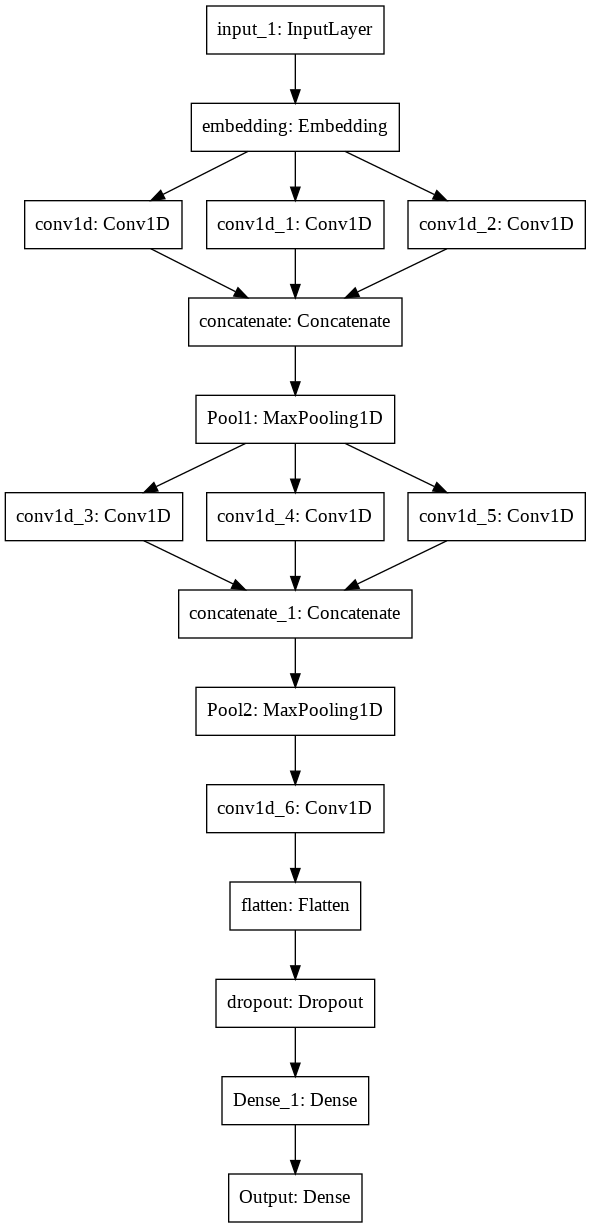

In [ ]:
plot_model(model, to_file='/content/gdrive/My Drive/Colab Notebooks/CNN on Text data/convolutional_neural_network_word_embedding.png')

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=200, callbacks=[callback, tensorboard_callback, stop_early])

Epoch 1/50
71/71 [==============================] - 12s 150ms/step - loss: 3.0704 - val_loss: 2.9409
train f1 score 0.08675
test f1 score 0.0854
Epoch 2/50
71/71 [==============================] - 10s 137ms/step - loss: 2.8786 - val_loss: 2.5453
train f1 score 0.11692
test f1 score 0.11557
Epoch 3/50
71/71 [==============================] - 10s 136ms/step - loss: 2.4706 - val_loss: 2.3421
train f1 score 0.16868
test f1 score 0.15764
Epoch 4/50
71/71 [==============================] - 10s 135ms/step - loss: 2.2671 - val_loss: 2.2470
train f1 score 0.22045
test f1 score 0.20076
Epoch 5/50
71/71 [==============================] - 10s 135ms/step - loss: 2.1293 - val_loss: 2.2545
train f1 score 0.25579
test f1 score 0.22881
Epoch 6/50
71/71 [==============================] - 10s 136ms/step - loss: 2.0373 - val_loss: 2.1672
train f1 score 0.29113
test f1 score 0.25366
Epoch 7/50
71/71 [==============================] - 10s 134ms/step - loss: 1.9414 - val_loss: 2.1602
train f1 score 0.30593
t

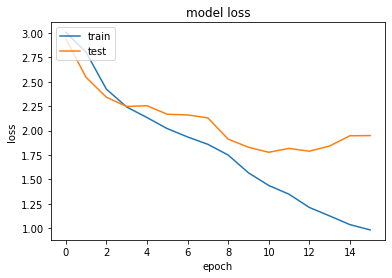

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
%tensorboard --logdir /content/gdrive/My Drive/Colab Notebooks/CNN on Text data/logs/fit

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2021-04-21 14:08:28.740676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
                   [--whatif-dat